# 02456 Deep Learning, Project Work 2019

## Supervised by Retune DSP

*Written by Nicklas Hansen*

This notebook is a small introduction to the project work that you will carry out in the coming weeks. While no experience in digital signal processing is required, it is a good idea to get familiar with basic signal processing, Fourier Transforms, MFCCs (if you're doing Voice Activity Detection) and impulse responses (if you're doing Reverberation Removal).

It is recommended to run the training of your neural networks on a GPU. If you do not have a GPU available on your local machine, you may want to use Google Colab for the project. Questions regarding PyTorch, GPU acceleration and Google Colab can be directed to Nicklas in the *#retune_dsp* Slack channel. You can also find him in Skylab (ground floor) every Monday afternoon.

### Group work

We highly encourage you to form groups of 2-3 members. If you’re a group of friends >3, consider splitting up into two smaller groups. You are allowed to discuss ideas with other groups, but in smaller groups you all get to implement a fair share (and thus learn more).
It is a good idea to create a git repo for your project work so that you all have access to the latest version. It is also a good way to show off your newly-developed deep learning skills to future employers!
If you divide the project work between group members, make sure that all members have an understanding of each others parts - you might get asked individual questions at the poster session.

### Voice Activity Detection

In smart audio projects such as Amazon Alexa, Google Voice Assistant or Apple Siri, microphones are always listening and continuously looking for a given wake-word, which initiates the cloud-based speech recognition and interaction.
To reduce power consumption, this process is typically carried out in multiple stages, with the first stage checking whether any speech is present or not.<br/>
In this project, we will investigate deep learning architectures for voice activity detection (VAD).

### Reverberation Removal

Acoustic reverberation is the reflection of audio from surfaces such as walls, furniture etc. and occurs virtually everywhere. When using hands-free smart audio devices the microphone is typically located far from the audio source, which can create strong reverberation artifacts. Our brains are quite good at speech comprehension regardless of reverberation, but it can seriously limit the effectiveness of automatic speech recognition systems and solutions to this problem is therefore of interest.<br/>
In this project, we will investigate how deep learning can be used to remove reverberation from speech signals.

## Dependencies

We recommend using [Librosa](https://librosa.github.io/librosa/index.html) for working with audio files as it is easy to use and has a fairly good documentation. We assume that you already have `numpy`, `matplotlib` and `torch` installed. 

## Data

For clean speech (i.e. no noise, no reverberation), we will be using a small subset of the open source [LibriSpeech ASR](https://www.openslr.org/12/) dataset. We provide the dataset for you in a 16kHz single-channel 32-bit ```.wav``` format.<br/>
We also provide you with noise data (for VAD) and impulse responses (for reverberation removal). All data can be downloaded from the link shared in the Slack channel. Note that the link expires January 1, 2020.

Note that it is a good idea to use a small subset of the data that we provide you during development. Once you have a working model, you can then scale up the data volume as much as you deem feasible.

If you place the data in a local directory (or in your Google Drive) and set ```data_directory``` to the relative path to that directory, you can use the below code to load your audio into Python using ```Librosa```. When loading an audio file using Librosa, you have to specify the sample rate explicitly; we do that by parsing in ```sample_rate``` to the ```sr``` argument.

Found 4154 files in the selected dataset.

Loaded an audio file with 32640 samples at a sample rate of 16 kHz.


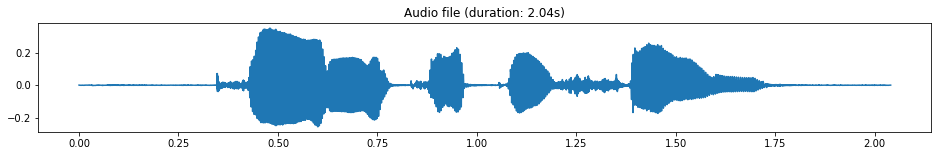

In [ ]:
import numpy as np
import glob
import librosa
import matplotlib.pyplot as plt
%matplotlib inline

data_directory = 'data'
sample_rate = 16e3


def get_filepaths(data_directory, dataset):
    """
    Returns a list of file paths for the specified dataset.
    """
    assert dataset in {'clean-speech', 'noise', 'impulse-responses'}
    
    regex = '/'.join((data_directory, dataset, '*.wav'))
    filepaths = glob.glob(regex)
    
    if len(filepaths) == 0:
        raise Exception('No files were found in the specified dataset!')
    
    return filepaths


def plot_audio(audio, labels=None, sample_rate=16000):
    audio_duration = len(audio_file)/sample_rate
    plt.figure(figsize=(16, 2))
    
    time_audio = np.linspace(0, audio_duration, num=len(audio_file))
    plt.plot(time_audio, audio_file)
    
    if labels is not None:
        time_labels = np.linspace(0, audio_duration, num=len(labels))
        plt.plot(time_labels, np.array(labels)/2)
        
    plt.title(f'Audio file (duration: {len(audio_file)/sample_rate}s)')
    plt.show()
    

dataset = get_filepaths(data_directory, dataset='clean-speech')
print(f'Found {len(dataset)} files in the selected dataset.\n')

audio_file, sr = librosa.load(dataset[0], sr=sample_rate)
print(f'Loaded an audio file with {len(audio_file)} samples at a sample rate of {int(sample_rate)//1000} kHz.')

plot_audio(audio_file, sample_rate=sample_rate)

## CUDA and GPU-acceleration

Below is a small example demonstrating how CUDA and GPU-acceleration can be set up in PyTorch. If you're running in Google Colab, make sure that you have a GPU available. You can select a GPU under *Runtime -> Change Runtime Type* in the top navigation bar.

In [ ]:
import torch
import torch.nn as nn

if torch.cuda.is_available():
    net = nn.Sequential(nn.Linear(2, 32), nn.ReLU(), nn.Linear(32, 1)).cuda()

    test_input = torch.randn(2).cuda()
    test_output = net(test_input).cpu()

    print(f'Output: {test_output.data.numpy()}')
    
else:
    print('A CUDA-capable GPU must be enabled for this example to work.')

A CUDA-capable GPU must be enabled for this example to work.


## If you're doing Voice Activity Detection

For the VAD project, you will need to add labels to your data. The simplest possible way to do this would be to label audio based on the energy alone. This would however not be very precise. A better way to do it is to load and use an already implemented VAD system to create our labels. This should yield fairly good results as we have clean speech data. A VAD that can be used out-of-the-box is the [WebRTCVad](https://pypi.org/project/webrtcvad/). Let's install it (and its dependencies) using pip:

In [ ]:
!pip install wave
!pip install webrtcvad

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


You should consider upgrading via the 'python -m pip install --upgrade pip' command.


We will have to do a bit of work to create the labels. The ```WebRTCVad``` expects a binary file as input, so we load a ```wav``` file in binary format using the ```wave``` package. The file then needs to be processed by WebRTCVad in small frames at a time, so we will have to write a function that does this for us. It is a good idea to store audio labels in one or more files. You can use the ```pickle``` package for that - see e.g. [this blog post](https://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/) for a quick guide on how to use pickle.

File contains 65280 bytes.


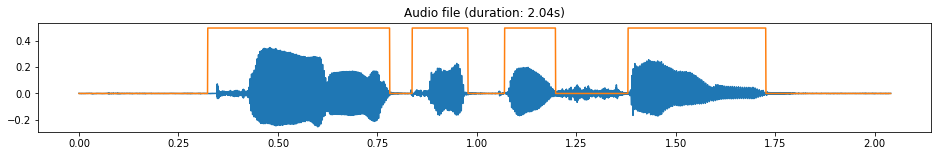

In [ ]:
import contextlib
import wave
import webrtcvad

vad = webrtcvad.Vad()

# Set the aggresiveness of the VAD (see documentation for more info)
vad.set_mode(3)

# Load a WAV file in binary format
def read_wav_as_binary(filename):
    with contextlib.closing(wave.open(filename, 'rb')) as wf:
        return wf.readframes(wf.getnframes())
    
pcm_data = read_wav_as_binary(dataset[0])
print(f'File contains {len(pcm_data)} bytes.')

frame_duration_ms = 30
num_bytes_per_frame = int(sample_rate * (frame_duration_ms / 1000.0) * 2)


def get_labels_for_frames(pcm_data, vad, frame_duration_ms, num_bytes_per_frame, sample_rate, step_size=20):
    frame_pos = 0
    while frame_pos < len(pcm_data) - num_bytes_per_frame:
        yield int(vad.is_speech(pcm_data[frame_pos:frame_pos+num_bytes_per_frame], int(sample_rate)))
        frame_pos += step_size


labels = list(get_labels_for_frames(pcm_data, vad, frame_duration_ms, num_bytes_per_frame, sample_rate))
plot_audio(audio_file, labels, sample_rate=sample_rate)

# For more example usage of WebRTCVad, see this link:
# https://github.com/wiseman/py-webrtcvad/blob/master/example.py

As can be seen, the WebRTCVad is not perfect, but it's good enough for our purposes. Now it's up to you to apply it to the full dataset! You may want to play around with the VAD aggressiveness, frame size and step size of the VAD to see what works best.

### Questions?

If you have any questions, be sure to reach out to us in the *#retune_dsp* channel on Slack or ask your fellow students.